In [109]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from pandas_profiling import ProfileReport
from matplotlib_venn import venn2

sns.set_style('darkgrid')

In [110]:
INPUT_DIR = '../input/titanic/'
OUTPUT_DIR = './'

os.makedirs(OUTPUT_DIR, exist_ok=True)

In [111]:
train_df = pd.read_csv(os.path.join(INPUT_DIR, 'train.csv'))
test_df = pd.read_csv(os.path.join(INPUT_DIR, 'test.csv'))

In [112]:
whole_df = pd.concat([train_df, test_df], ignore_index=True)

In [113]:
whole_df.dtypes

PassengerId      int64
Survived       float64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [114]:
train_df.head().T

,0,1,2,3,4
PassengerId,1,2,3,4,5
Survived,0,1,1,1,0
Pclass,3,1,3,1,3
Name,"Braund, Mr. Owen Harris","Cumings, Mrs. John Bradley (Florence Briggs Th...","Heikkinen, Miss. Laina","Futrelle, Mrs. Jacques Heath (Lily May Peel)","Allen, Mr. William Henry"
Sex,male,female,female,female,male
Age,22,38,26,35,35
SibSp,1,1,0,1,0
Parch,0,0,0,0,0
Ticket,A/5 21171,PC 17599,STON/O2. 3101282,113803,373450
Fare,7.25,71.2833,7.925,53.1,8.05


In [115]:
#report = ProfileReport(train_df)
#report.to_file(os.path.join(OUTPUT_DIR, 'train_report.html'))

In [116]:
#report2 = ProfileReport(test_df)
#report2.to_file(os.path.join(OUTPUT_DIR, 'test_report.html'))

In [117]:
def create_continuous_features(input_df):
    use_columns = [
        "PassengerId",
        "SibSp",
        "Parch",
        "Age",
        "Fare",
    ]
    return input_df[use_columns].copy()

In [118]:
assert create_continuous_features(train_df).equals(create_continuous_features(train_df))

In [119]:
#"Cabin","Embarked","Name","Sex","Ticket","Survived"

In [120]:
train_df['Sex'].replace(['male','female'], [0,1], inplace=True)
test_df['Sex'].replace(['male','female'], [0,1], inplace=True)

In [121]:
train_df['Embarked'].fillna(('S'), inplace=True)
test_df['Embarked'].fillna(('S'), inplace=True)

In [122]:
train_df['Embarked'] = train_df['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
test_df['Embarked'] = test_df['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

In [123]:
#test_df['Survived']='nan'
#test_df['Survived']

In [124]:
def create_category_features(input_df):
    use_columns = [     
        "Pclass",
        "Embarked",
        "Sex",
    ]
    return input_df[use_columns].copy()

In [125]:
# https://github.com/nyk510/vivid/blob/master/vivid/utils.py
from contextlib import contextmanager
from time import time

@contextmanager
def timer(logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None):
    if prefix: format_str = str(prefix) + format_str
    if suffix: format_str = format_str + str(suffix)
    start = time()
    yield
    d = time() - start
    out_str = format_str.format(d)
    if logger:
        logger.info(out_str)
    else:
        print(out_str)

In [126]:
from tqdm import tqdm

def to_feature(input_df):
    processors = [
        create_continuous_features,
        create_category_features
    ]
    
    out_df = pd.DataFrame()
    
    for func in tqdm(processors, total=len(processors)):
        with timer(prefix='create ' + func.__name__ + ' '):
            _df = func(input_df)
        
        assert len(_df) == len(input_df), func.__name__
        out_df = pd.concat([out_df, _df], axis=1)
        
    return out_df

In [127]:
train_df['Survived']

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64

In [128]:
train_feat_df = to_feature(train_df)
test_feat_df = to_feature(test_df)

100%|██████████| 2/2 [00:00<00:00, 434.62it/s]

create create_continuous_features 0.002[s]
create create_category_features 0.001[s]
create create_continuous_features 0.002[s]
create create_category_features 0.001[s]


In [129]:
assert len(test_feat_df) == len(test_df)

In [130]:
from sklearn.metrics import average_precision_score
import lightgbm as lgbm

def pr_auc(y_true, y_pred):

    score = average_precision_score(y_true, y_pred)
    return "pr_auc", score, True

def fit_lgbm(X, y, cv, params: dict=None, verbose=100):

    if params is None:
        params = {}

    models = []

    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (idx_train, idx_valid) in enumerate(cv): 

        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = lgbm.LGBMClassifier(**params)
        
        with timer(prefix='fit fold={} '.format(i + 1)):
            clf.fit(x_train, y_train, 
                    eval_set=[(x_valid, y_valid)],  
                    early_stopping_rounds=verbose, 
                    eval_metric=pr_auc,
                    verbose=verbose)

        pred_i = clf.predict_proba(x_valid)[:, 1]
        oof_pred[idx_valid] = pred_i
        models.append(clf)

        print(f'Fold {i} PR-AUC: {average_precision_score(y_valid, pred_i):.4f}')

    score = average_precision_score(y, oof_pred)
    print('FINISHED \ whole score: {:.4f}'.format(score))
    return oof_pred, models

In [131]:
params = {
    'objective': 'binary',
    'learning_rate': .1,
    'max_depth': 6,
    'n_estimators': 10000,
    'colsample_bytree': .7
}

y = train_df['Survived'].values

In [132]:
from sklearn.model_selection import StratifiedKFold

fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=71)
cv = list(fold.split(train_feat_df, y)) # もともとが generator なため明示的に list に変換する

In [133]:
oof, models = fit_lgbm(train_feat_df.values, y, cv, params=params)

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.500061	valid_0's pr_auc: 0.84283
Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.586294	valid_0's pr_auc: 0.883333
fit fold=1 0.151[s]
Fold 0 PR-AUC: 0.8833
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.525293	valid_0's pr_auc: 0.788064
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.507418	valid_0's pr_auc: 0.834263
fit fold=2 0.134[s]
Fold 1 PR-AUC: 0.8343
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.457663	valid_0's pr_auc: 0.827484
Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.426015	valid_0's pr_auc: 0.840262
fit fold=3 0.159[s]
Fold 2 PR-AUC: 0.8403
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.551811	valid_0's pr_auc: 0.777037
Early stopping, best iteration is:
[9]	valid_0's bi

In [134]:
def visualize_importance(models, feat_train_df):

    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(max(6, len(order) * .4), 7))
    sns.boxenplot(data=feature_importance_df, x='column', y='feature_importance', order=order, ax=ax, palette='viridis')
    ax.tick_params(axis='x', rotation=90)
    ax.grid()
    fig.tight_layout()
    return fig, ax

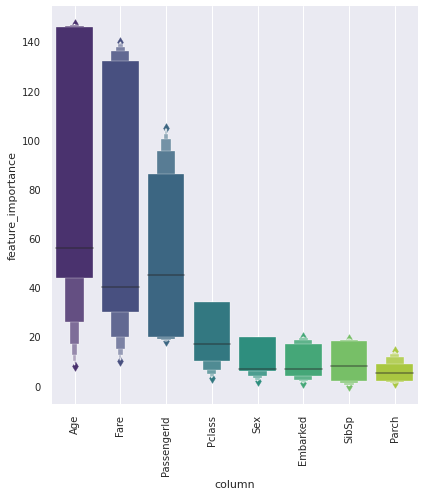

In [135]:
fig, ax = visualize_importance(models, train_feat_df)

In [136]:
pred = np.array([model.predict_proba(test_feat_df.values)[:, 1] for model in models])
pred = np.mean(pred, axis=0)
sub_df = pd.DataFrame({'Survived': pred})
sub_df

,Survived
0,0.173061
1,0.332135
2,0.185751
3,0.231768
4,0.383446
...,...
413,0.192643
414,0.746513
415,0.164433
416,0.192643


In [137]:
len(sub_df)

418

In [138]:
sub_df['Survived'][0]

0.1730608495326584

In [139]:
sub2_df=[]
for i in range(len(sub_df)):
    if sub_df['Survived'][i] < 0.5:
        sub2_df.append(0)
    else:
        sub2_df.append(1)
sub2_df

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,


In [140]:
my_submit0 = ['PassengerId']
my_submit1 = ['Survived']

for i in range(0, len(sub2_df)):
    my_submit0.append(str(892+i))
    my_submit1.append(str(sub2_df[i]))

    
my_submit=[]

my_submit.append(my_submit0)
my_submit.append(my_submit1)

my_submit2=np.transpose(my_submit)
my_submit2

NameError: name 'y_pred' is not defined

In [ ]:
my_submit3 = pd.DataFrame(my_submit2)
my_submit3.to_csv(os.path.join(OUTPUT_DIR,'titanic_submission.csv'), index=False, header=False)